</br>
<div style="display: flex; justify-content: space-between; align-items: flex-start; border-bottom: 2px solid #555555; padding-bottom: 15px; margin-bottom: -8px;">
    <div style="width: 50%;">
        <h2>
            <span style="color: #B30033;">▍</span>Práctica 1:
        </h2>
        <h1 style="margin-top: -10px;">
            Análisis, procesamiento y predicción supervisada
        </h1>
    </div>
    <div style="width: 50%; text-align: right;">
        <div style="display: flex; justify-content: space-between; align-items: flex-start; margin-top: 30px;">
            <div style="width: 20%;"></div>
            <div style="width: 80%; border-left: 2px solid #555555; padding-left: 20px;">
                <div style="margin-bottom: 20px;">
                    <p style="margin: 0; font-size: 1.4em; font-weight: bold;">
                        Aprendizaje Automático, 2025-26
                    </p>
                </div>
                <div style="margin-top: 8px; text-align: right;">
                    <span style="font-size: 1em; color: #D0D0D0;">
                        José Miguel Puerta Callejón
                    </span>
                    <a href="mailto:Jose.Puerta@uclm.es" style="text-decoration: none; color: #888888; font-size: 0.8em; padding-left: 15px;">
                        ✉ Jose.Puerta@uclm.es
                    </a>
                </div>
                <div style="margin-top: 8px; text-align: right;">
                    <span style="font-size: 1em; color: #D0D0D0;">
                        Pablo Torrijos Arenas
                    </span>
                    <a href="mailto:Pablo.Torrijos@uclm.es" style="text-decoration: none; color: #888888; font-size: 0.8em; padding-left: 15px;">
                        ✉ Pablo.Torrijos@uclm.es
                    </a>
                </div>
                </div>
            </div>
        </div>
    </div>
</div>

<div style="border-bottom: 2px solid #555555; padding-bottom: 25px; margin-bottom: 10px">
    <div style="display: flex; align-items: center; margin-bottom: 10px;">
        <span style="color: #B30033; font-size: 1.5em; margin-right: 10px;">▍</span>
        <h3 style="margin: 0; font-size: 1.4em; font-weight: bold">
            Estudiantes
        </h3>
    </div>
    <ul style="list-style-type: none; padding-left: 28px; margin: 0;  font-size: 1.1em">
        <li>Víctor Ortega Gómez</li>
        <li>Cristian Rubio Barato</li>
    </ul>

</div>

## 1. Introducción

El objetivo de esta práctica es aplicar un flujo de trabajo completo de **aprendizaje automático** para resolver un problema de **clasificación supervisada**. Se analizará un conjunto de datos simulado sobre visitas de pacientes a un hospital para predecir el **riesgo cardiovascular**.

El desarrollo abarcará todas las etapas del proceso:
* **Análisis Exploratorio de Datos (EDA)** y su **preprocesamiento**.
* **Selección y entrenamiento** de diversos modelos de clasificación.
* **Validación** robusta de los modelos (ej. validación cruzada) y ajuste de hiperparámetros.
* **Generación de predicciones** para la evaluación final.

El rendimiento de los modelos se evaluará en una competición privada en Kaggle.

<div style="border-bottom: 2px solid #555555; padding-bottom: 15px; margin-bottom: 10px"></div>

## 2. Carga y visualización de los datos

Se proporciona un conjunto de datos que registra visitas de pacientes. Los datos contienen una variedad de tipos de variables, valores faltantes y otros artefactos que deberán ser gestionados.

Comenzamos importando las librerías necesarias y cargando los conjuntos de datos de entrenamiento (`cardio_risk_train.csv`) y de prueba (`cardio_risk_test.csv`) para poder examinarlos:

In [1]:
!pip install dython --quiet # Será necesario para tener la librería en Google Collab y posteriormente importarla

ERROR: Invalid requirement: '#': Expected package name at the start of dependency specifier
    #
    ^


In [2]:
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', None)

df_train = pd.read_csv('cardio_risk_train.csv')
df_test = pd.read_csv('cardio_risk_test.csv')

# 3. Importación de librerías y configuraciones

Se importarán las librerías necesarias tanto para la ejecución de la práctica y modelos como para el análisis exploratorio de los datos.

In [3]:
# Standard
import warnings

# Third party
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
from dython.nominal import associations

# Sklearn - Modelado
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score, StratifiedKFold, RandomizedSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import (
    FunctionTransformer,
    OneHotEncoder,
    PowerTransformer,
    StandardScaler,
)
from sklearn import set_config

from sklearn.metrics import (
    classification_report,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
     confusion_matrix,  # ← Faltaba esta
    roc_curve, 
)
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier,
    VotingClassifier,
)
from sklearn.tree import DecisionTreeClassifier

# Boosted models
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from scipy.stats import randint, uniform

Configuración para la visualización de las gráficas

In [4]:
%matplotlib inline
figsize = (12, 7)  # Width, height in inches
palette = "colorblind"  # Palette definition
plt.rcParams["figure.figsize"] = figsize
sns.set_palette(palette)

Fijamos una semilla para la reproducibilidad de los experimentos

In [5]:
random_state = seed = 41686

Configuración de pandas para siempre devolver un dataset pandas y no numpy de forma que se facilite el procesamiento de los datos

In [6]:
transform_output = "pandas"  # Pandas output
set_config(transform_output=transform_output)

Desactivación de mensajes de advertencia para evitar resultados de las celdas demasiado largos

In [7]:
action = "ignore"  # Never print matching warnings
warnings.filterwarnings(action)

El dataset ya está dividido en una parte para training y otra para testing por lo que nos saltaremos dicho paso. Esta división es importante para realizar un análisis exploratorio de datos únicamente con el dataset de training para evitar el *data leakage* o fuga de datos.

Lo que sí haremos es definir la variable que queremos predecir

In [8]:
target = "riesgo_cv"
axis = "columns"

# Separar X e y en el conjunto de entrenamiento
X_train = df_train.drop(target, axis=1) # Nos quedamos con las variables que predicen riesgo_cv
y_train = df_train[target] # Separamos la columna de riesgo_cv

n = 5
X_train.sample(n, random_state=random_state)

,id,fecha_visita,edad,altura_cm,peso_kg,imc,presion_sistolica_1,presion_sistolica_2,presion_sistolica_3,colesterol_total,hdl,ldl,glucosa_ayunas,fumador,actividad_fisica,antecedentes_familiares,codigo_postal,hospital_origen,notas_medicas,talla_zapato
23823,10230,2020-05-25 22:48:41.789084,40,179,73.4,22.8,108.6,121.7,130.9,154.0,51.1,86.9,NaN,0.0,poco,0,3139,HOSP-014,"No Supera Los 2 Cigarrillos Al Día, Según Refi...",43
14945,13821,2021-04-26 07:33:58.789084,39,177,63.3,20.1,103.9,117.0,110.6,167.8,49.2,107.6,NaN,0.0,~4.0 horas,1,41004,HOSP-016,NaN,39
6886,4691,2018-12-25 11:29:40.789084,63,168,64.7,22.9,129.7,129.1,111.0,157.8,46.7,102.3,99.2,0.0,~3.0 horas,0,36313,HOSP-002,"Consumo puntual de cigarrillos, no continuado.",35
12897,10599,2020-06-30 05:27:50.789084,34,148,48.6,22.1,110.6,108.0,97.8,152.9,51.3,88.0,NaN,0.0,"6,1 horas",0,7008,HOSP-019,La Dieta Del Paciente Es Un Modelo De Equilibr...,37
7448,12514,2020-12-29 19:34:53.789084,64,162,85.1,32.2,149.4,149.5,138.7,163.7,36.6,111.0,81.8,NaN,mucho,0,2008,HOSP-004,"EL CUMPLIMIENTO ES TOTAL Y VOLUNTARIO, COMO PA...",35


## 4. Análisis exploratorio de los datos

En esta parte del cuaderno se realizará un análisis exploratorio de los datos y se comentarán las diferentes observaciones y las decisiones que se tomarán en función de dichas observaciones

### 4.1 Análisis de la variable objetivo

Primero realizaremos un análisis de la variable que se quiere predecir para ver cómo de balanceadas están las clases y detectar si será necesario un ajuste de los pesos del modelo.


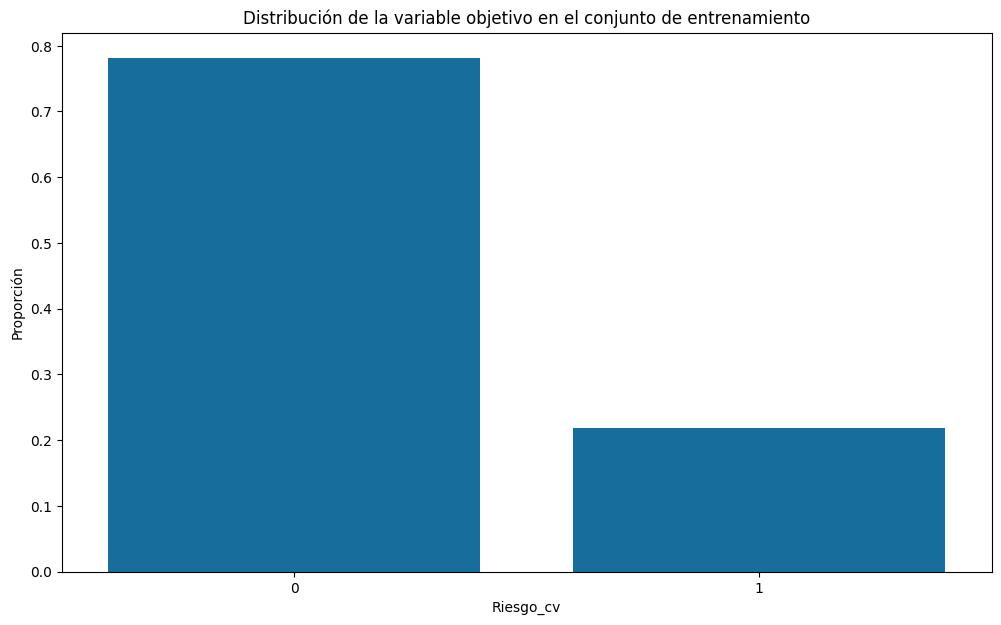

In [9]:
# Plot the distribution of the target variable
stat = "proportion"  # Normalize to proportions
title = "Distribución de la variable objetivo en el conjunto de entrenamiento"  # Text to use for the title
xlabel = "Riesgo_cv"  # Text to use for the x-axis label
ylabel = "Proporción"  # Text to use for the y-axis label
sns.countplot(x=y_train, stat=stat)
plt.title(title)
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.show()

Cómo se puede observar, el conjunto de datos se encuentra desbalanceado lo cuál tendrá un impacto en la evaluación del modelo ya que un modelo que siempre prediga *riesgo_cv* a 0 presentará una mayor tasa de acierto sin ser un buen clasificador.

### 4.2 Análisis de las variables predictoras

#### 4.2.1 Análisis de las variables numéricas

Para el análisis de las variables numéricas comenzaremos con el uso de `.describe()` con lo que obtendremos métricas claves. Se busca:

* **Escalas:** Diferencias drásticas en los rangos.
* **Valores extremos:** Diferencias grandes entre el 75% (`Q3`) y el máximo (`max`).
* **Asimetría:** Si la media es muy diferente de la mediana (`Q2`).

In [10]:
numerical_features = X_train.select_dtypes(include='number').columns.tolist()
X_train[numerical_features].describe().T

,count,mean,std,min,25%,50%,75%,max
id,24000.0,11999.500000,6928.347566,0.0,5999.75,11999.5,17999.250,23999.0
edad,24000.0,56.910917,15.857098,30.0,43.00,57.0,71.000,84.0
altura_cm,24000.0,167.686875,9.203348,135.0,161.00,167.0,174.000,201.0
peso_kg,24000.0,69.713275,13.735978,41.2,60.10,69.5,79.125,124.8
imc,24000.0,24.516100,3.718511,13.2,22.00,24.5,27.100,40.5
presion_sistolica_1,24000.0,125.952754,13.968335,86.5,117.00,125.5,134.000,296.6
presion_sistolica_2,24000.0,125.992633,14.185470,84.0,117.10,125.6,134.000,299.4
presion_sistolica_3,24000.0,126.078767,14.460630,84.7,117.10,125.5,134.100,299.2
colesterol_total,24000.0,190.673213,59.118220,89.1,170.70,185.4,200.400,999.8
hdl,24000.0,42.632292,7.259572,28.1,36.40,42.6,48.900,57.1


Se puede observar que hay problemas de escalas ya que las variables presentan rangos de valores bastante diferentes entre sí por lo que se deberá de realizar una normalización de los datos.

También se puede observar que el *count* no es 24000 para todas las variables por lo que existen algunas que presentan valores nulos o perdidos por lo que se deberá de realizar un tratamiento de esas variables. Un ejemplo de esto es glucosa_ayunas. Para este tipo de variables se aplicará la moda en los valores que sean *null*

Se puede observar que ciertas variables presentan también valores extremos debido a que el valor máximo encontrado dista mucho del *Q3* como por ejemplo *presión_sistolica_2*. Para mitigar esto se hará uso de la transformación de potencia.

Respecto al desbalance de las muestras no se han observado grandes diferencias en *Q2* con respecto a la media por lo que no hay desbalance para ninguna de estas variables

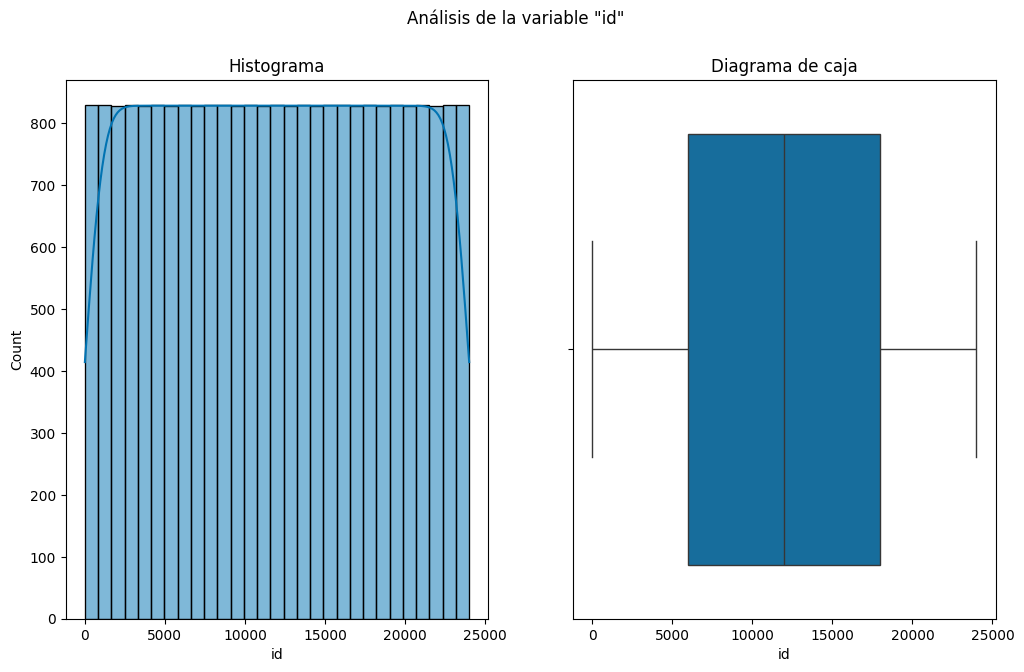

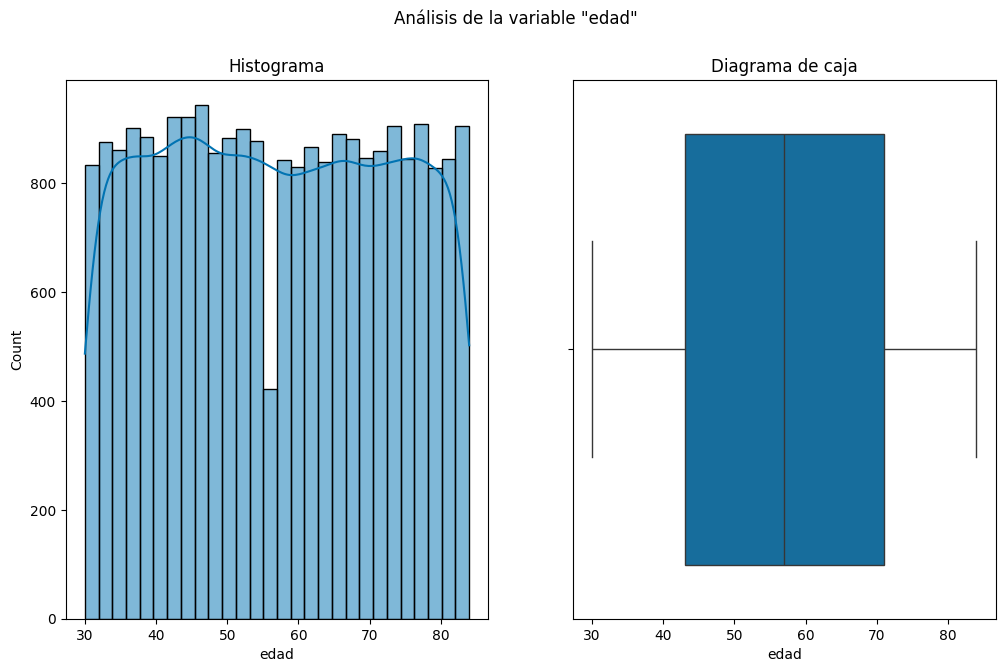

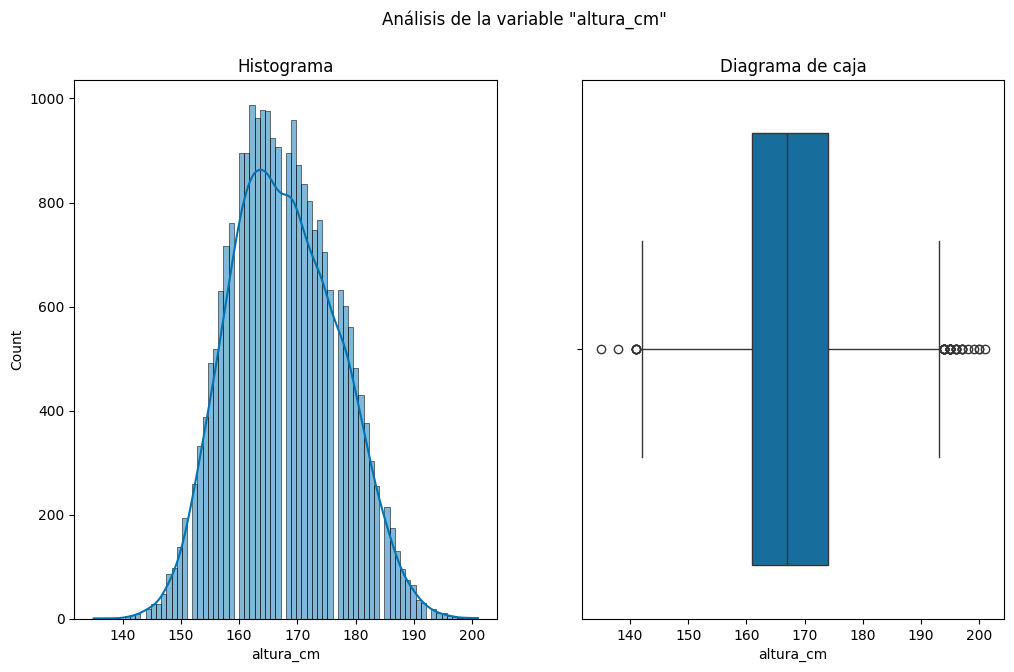

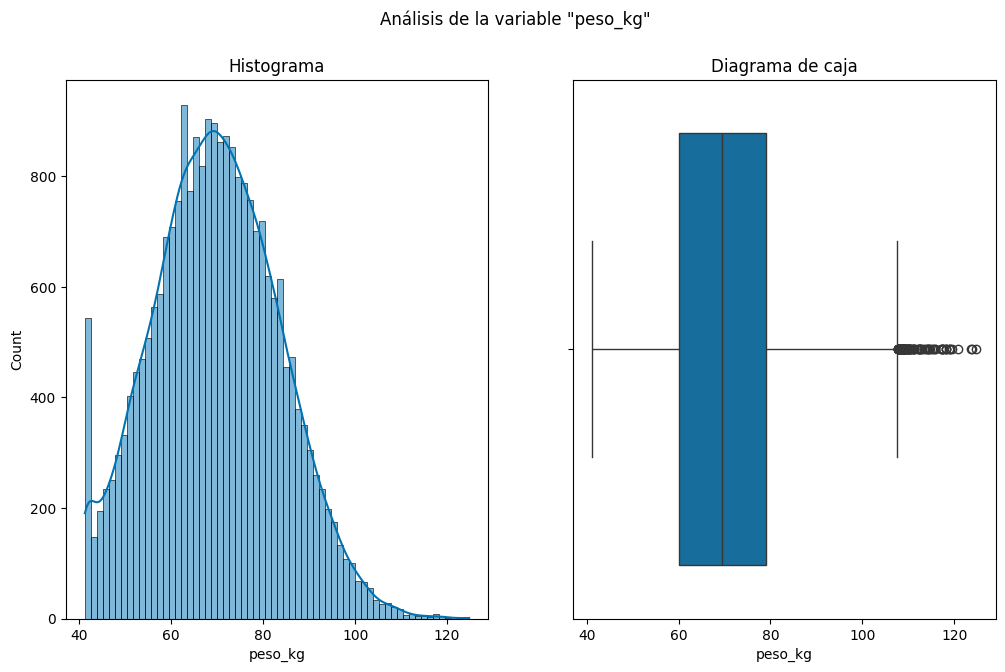

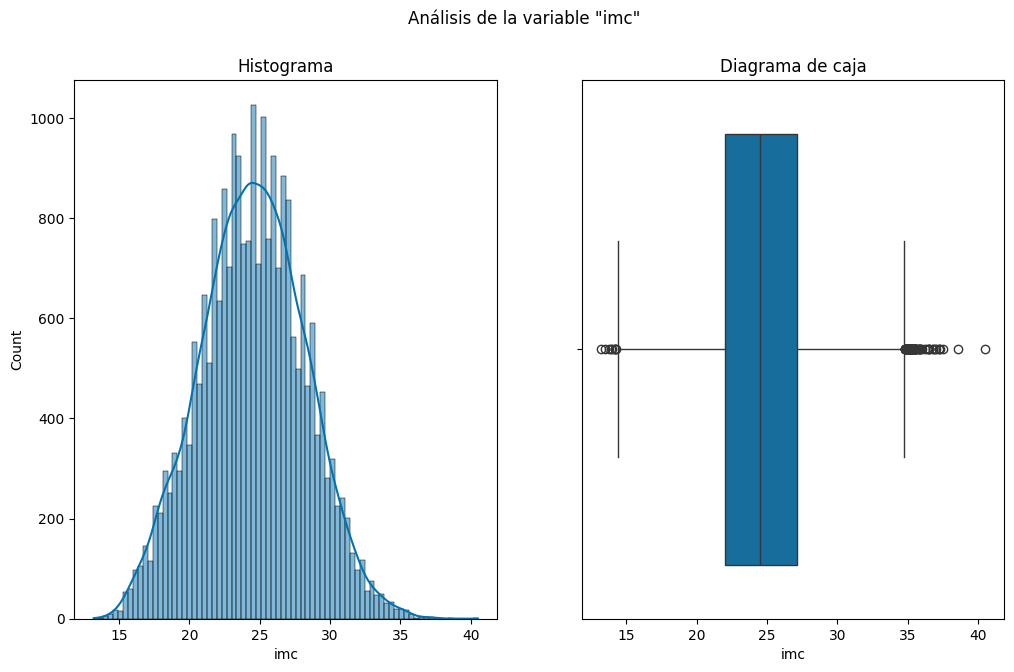

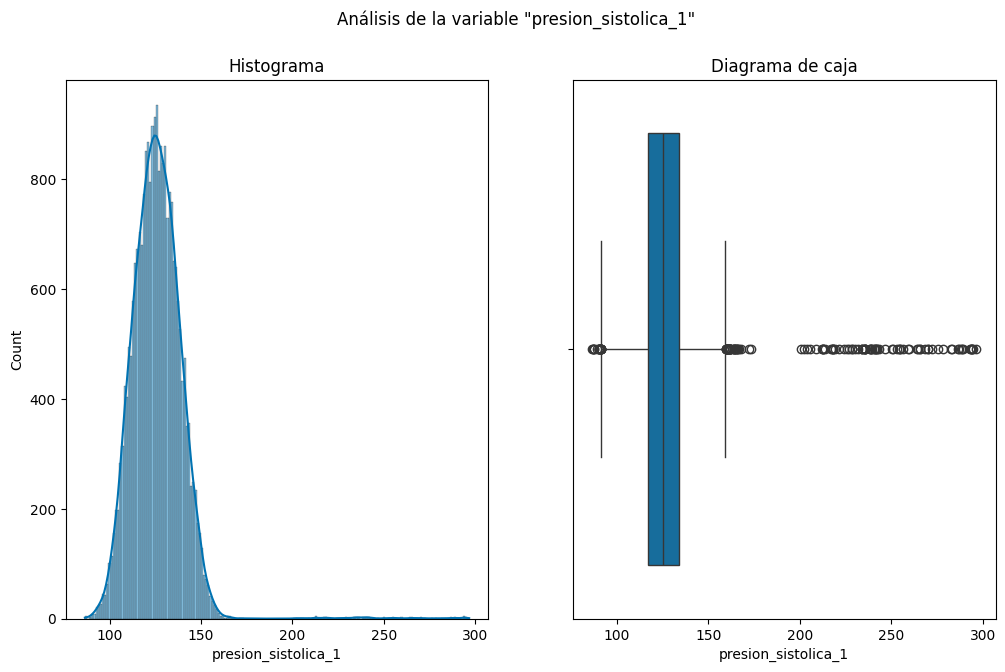

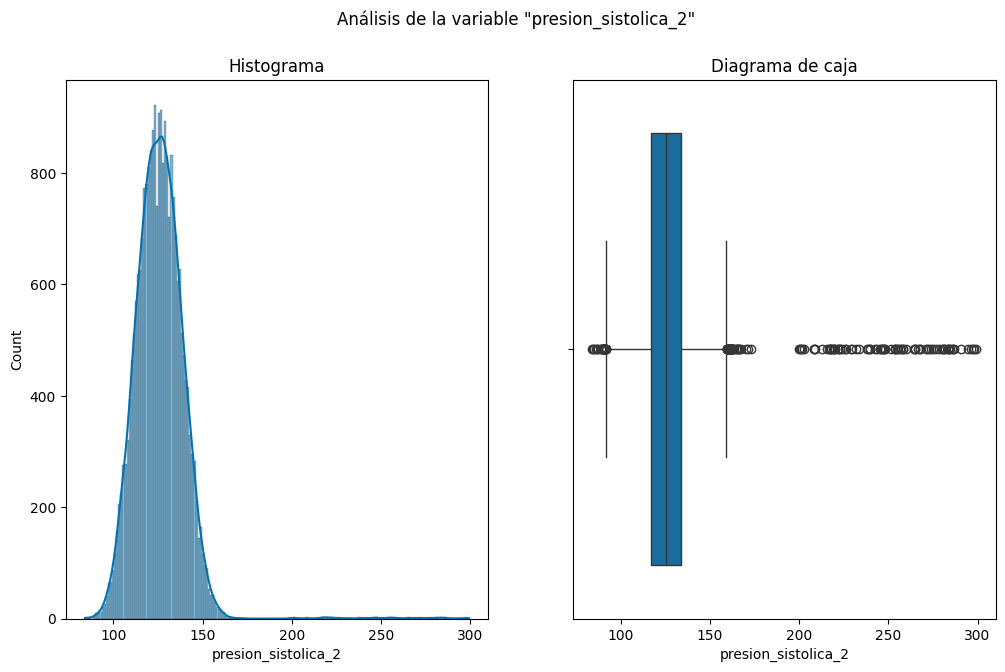

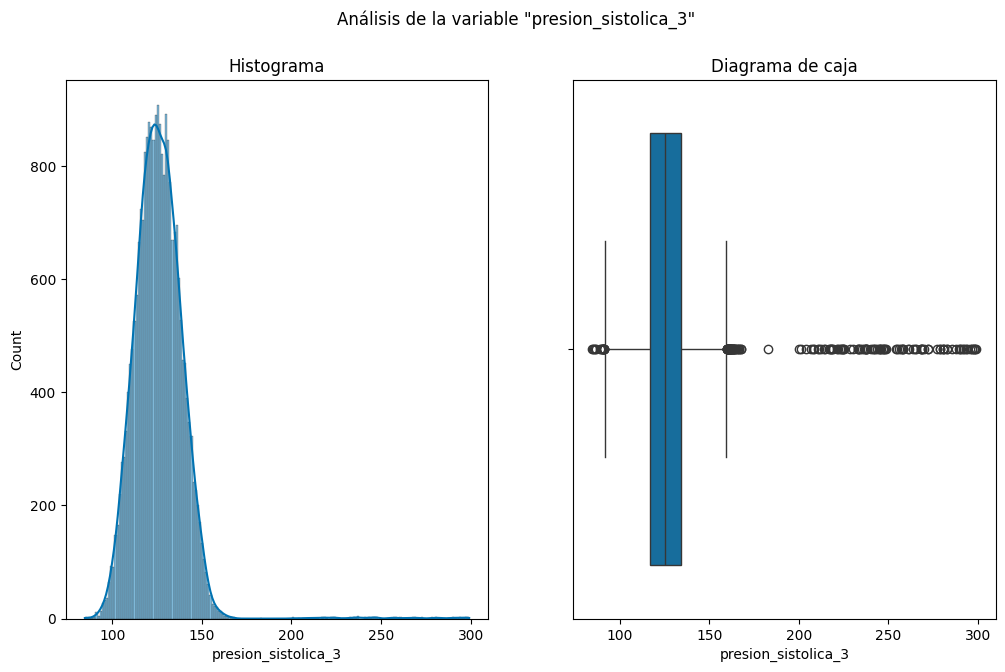

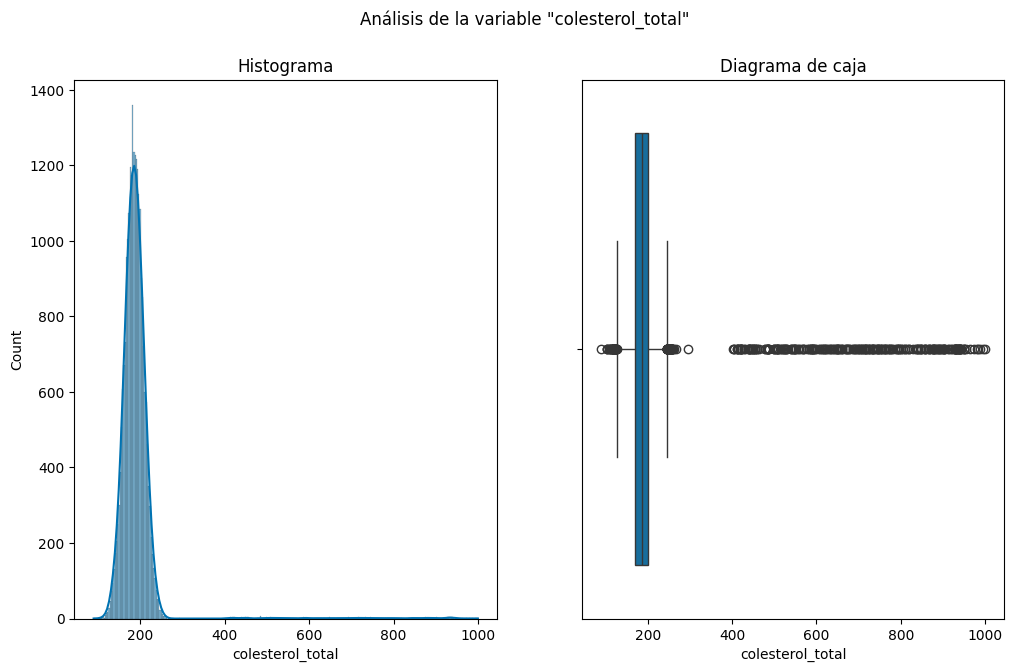

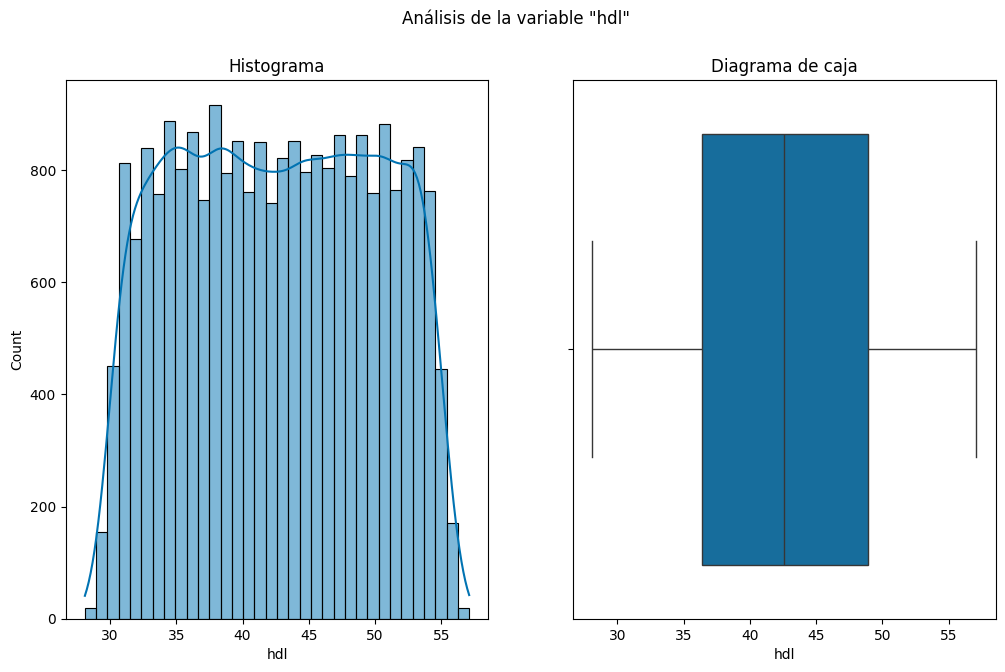

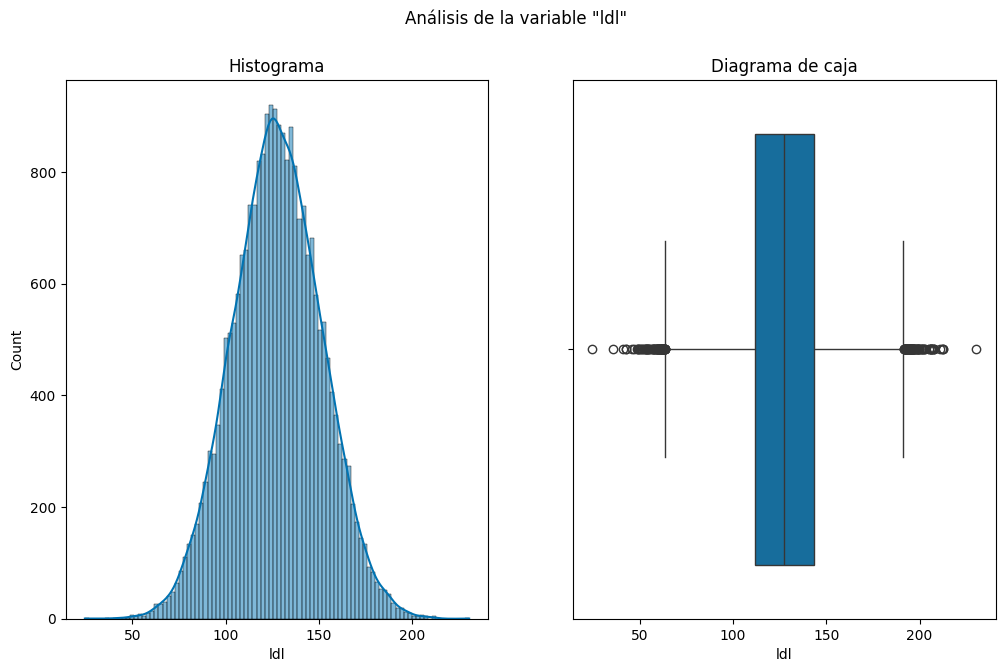

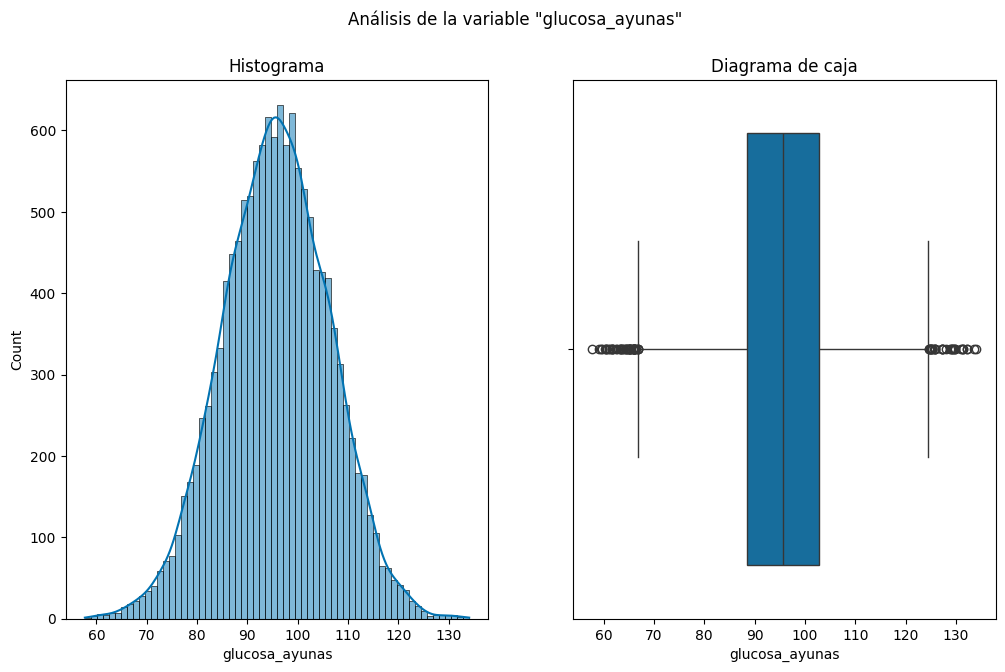

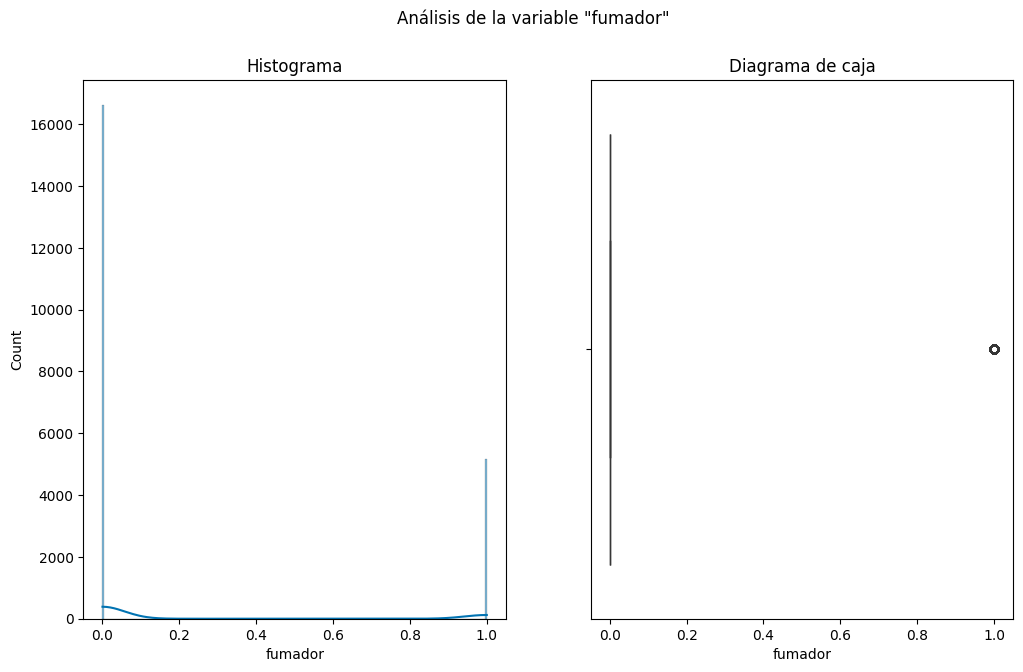

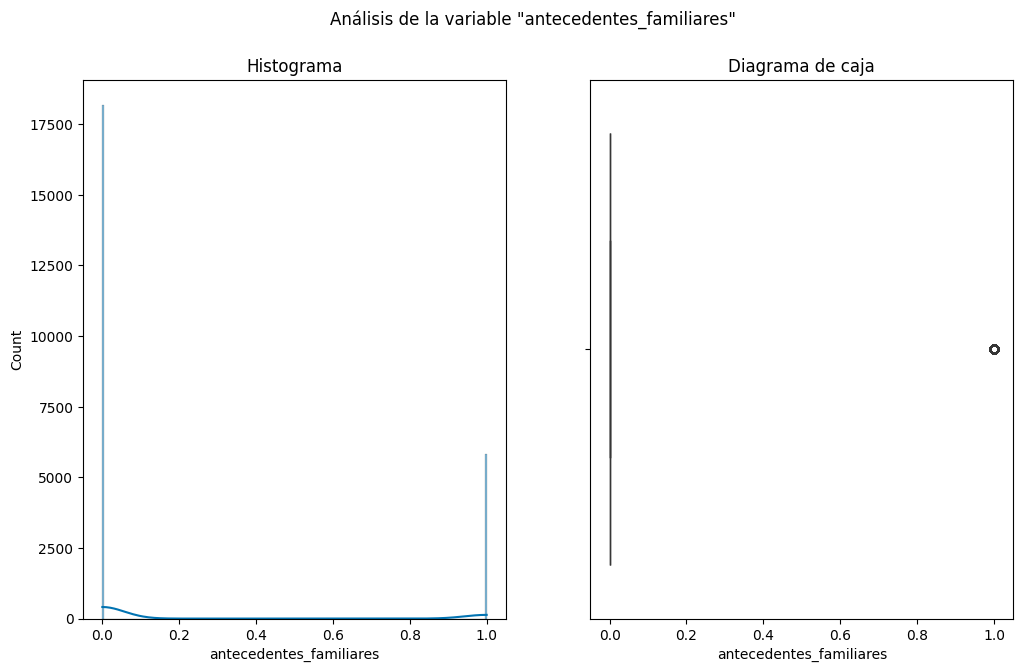

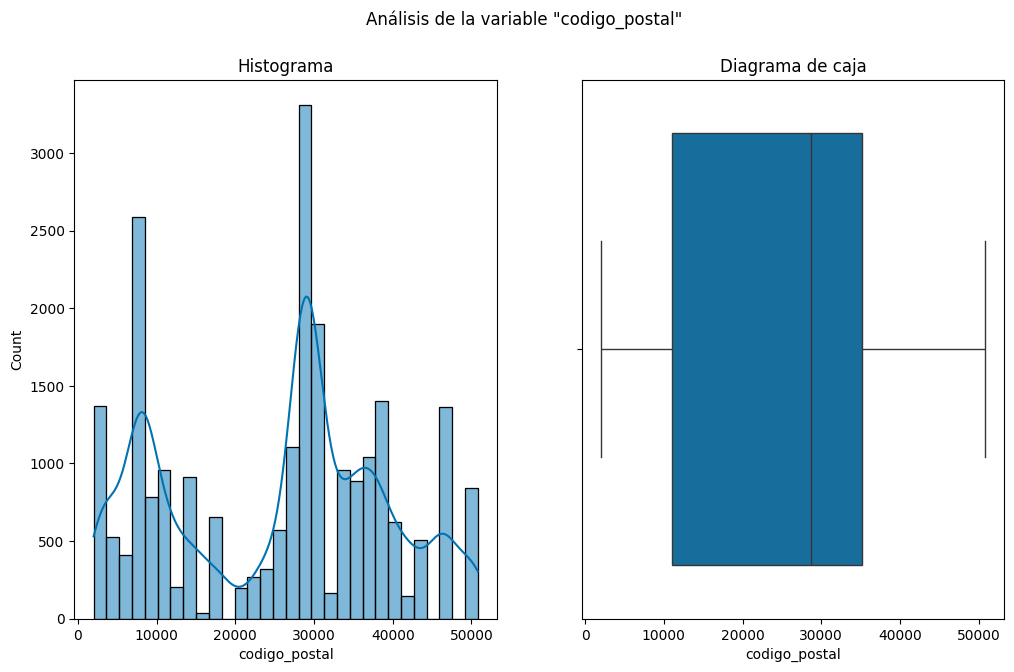

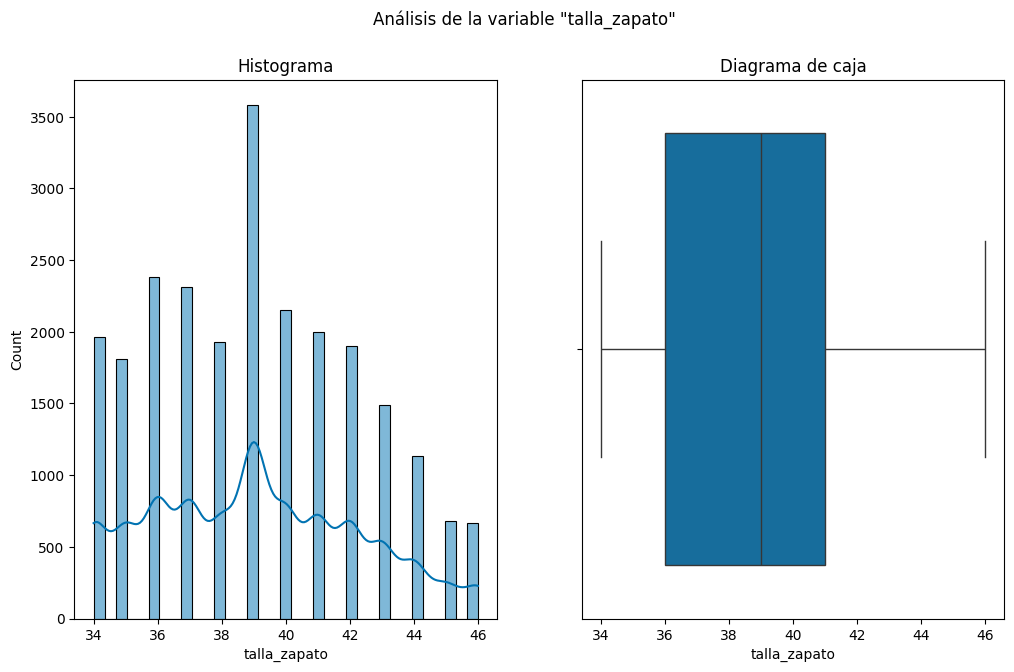

In [11]:
# Create plots
for column in numerical_features:
    # Set up the figure
    plt.figure()

    # Plot 1: Histogram
    plt.subplot(1, 2, 1)
    x = X_train[column]
    kde = True  # Compute a kernel density estimate to smooth the distribution
    title = f"Histograma"
    sns.histplot(x=x, kde=kde)
    plt.title(title)

    # Plot 2: Boxplot
    plt.subplot(1, 2, 2)
    x = X_train[column]
    title = f"Diagrama de caja"
    sns.boxplot(x=x)
    plt.title(title)

    suptitle = f'Análisis de la variable "{column}"'  # Text to use for the title of the entire figure
    plt.suptitle(suptitle)

Cómo se puede observar en las gráficas, es necesario un escalado debido a que las variables cuentan con escalas muy diferentes. También se puede ver la existencia de valores extremos claros para ciertas variables.

Todas las variables se encuentran también distribuidas excepto con dos casos especiales. Estas variables son *fumador* y *antecedentes_familiares*. Estas dos variables toman unicamente los valores 0 y 1 lo que nos indica que estas variables que son númericas en realidad representan variables categóricas donde 0 significa que no es fumador o no tiene antecedentes familiares y donde 1 significa lo opuesto.

#### 4.2.2 Análisis de las variables categóricas

Ahora, analizaremos las variables categóricas de las que no nos interesa la media o la mediana como con las númericas, sino que nos interesan:

* **Cardinalidad:** Cuántos valores únicos (`unique`) tiene cada una. Una cardinalidad alta (muchas categorías) puede ser problemática.
* **Frecuencia:** Cuál es el valor más frecuente (`top`) y cuántas veces aparece (`freq`).
* **Valores faltantes ocultos:** Si el valor más frecuente (`top`) o la lista de valores únicos revela la presencia de `"unknown"` u otros marcadores.

In [12]:
categorical_features = X_train.select_dtypes(include="object").columns.tolist()
X_train[categorical_features].describe().T

,count,unique,top,freq
fecha_visita,24000,23998,2020-12-24 12:46:25.789084,2
actividad_fisica,24000,303,nada,1768
hospital_origen,24000,20,HOSP-005,1269
notas_medicas,19167,4955,Su Alimentación Carece De Un Patrón Predecible.,17


Podemos observar que todas las variables presentan una gran cantidad de valores unicos (*unique*), pero *fecha_visita*, *notas_medicas* y *actividad_fisica* son especiales ya que son variables que tienen valores únicos no por categorías sino porque una son fechas y las otras son notas escritas a mano. Estas variables deberán de ser eliminadas debido a que no se pueden procesar correctamente para aportar información al modelo.

Por otro lado *hospital_origen*, aunque tiene una alta cardinalidad, entra dentro de lo entendible debido a que son identificadores de hospitales por lo que esta variable sí podría ser tratada con un one-hot encoding.

Respecto a valores pérdidos ninguna los presenta a excepción de *notas_medicas* pero como esa variable va a ser eliminada no es relevante.

In [ ]:
for column in categorical_features:
    # Set up the figure
    plt.figure()

    # Plot: Count plot
    y = X_train[column]
    order = X_train[column].value_counts().index  # Sort the bars by frequency for better readability
    stat = "proportion"  # Normalize to proportions
    sns.countplot(y=y, order=order, stat=stat)
    title = f'Diagrama de barras para "{column}"'
    xlabel = column
    ylabel = "Proporción"
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

Como se puede observar en los gráficos, las variables presentan una cardinalidad exagerada a excepción de *hospital_origen*. Esta variable se puede observar bien y comprobar que ninguna categoría predomina sobre otra por lo que se encuentra balanceada.

### 4.2.3 Análisis en profundidad de los valores perdidos o nulos

A pesar de que ya hemos podido ver que práctiamente no existen valores perdidos o nulos, vamos a realizar un análisis en mayor profundidad para conocer exactamente cúantos hay y las variables en las que se concentran.

In [ ]:
df = X_train.copy()
mapping = {"unknown": pd.NA}
df = df.replace(mapping)
msno.matrix(df)

Cómo se puede ver existen unicamente 3 variables que presentan valores perdidos. Una de ellas es *notas_medicas* que ya se decidió que sería eliminada por lo que no nos interesa.

*fumador* no presenta un alto número de valores nulos o perdidos. Debido a que representa si alguien es fumador o no, en vez de completar esos valores nulos con la moda como se decidió en un principio, se hará poniendo el número 2 indicando que se desconoce la información.

*glucosa_ayunas* presenta una gran cantidad de valores perdidos por lo que la mejor opción será eliminarla para no introducir ruido en los datos



### 4.2.4 Detección de duplicados e inconsistencias

Procederemos a la detección de entradas de datos duplicadas y la verificación de inconsistencias básicas, como formatos incorrectos o valores fuera de los rangos esperados, con el fin de garantizar la calidad y coherencia del conjunto de datos. Dado que ya se realizó una revisión de los rangos durante la exploración inicial de las variables, no es necesario volver repetir este análisis.

In [ ]:
duplicates = df_train.duplicated()
num_duplicates = duplicates.sum()
print(f"Número de filas duplicadas: {num_duplicates}")

No se han encontrado entradas de datos duplicadas.

También es posible identificar duplicados parciales, es decir, registros que comparten el mismo identificador pero presentan diferencias en otros campos.

In [ ]:
# Detect duplicate indices
keep = False  # Mark all duplicates as "True"
mask = df.index.duplicated(keep=keep)
duplicated_indices = df.index[mask]

# Filter records with duplicate indices
duplicated_records = df.loc[duplicated_indices]

# Verify if, for each duplicated index, the records are different
# Group by index and check if there are multiple unique rows
level = 0  # Group by index level
function = lambda group: group.drop_duplicates().shape[0] > 1
grouped = duplicated_records.groupby(level=level).filter(function)

# Display the found records
print("Duplicados parciales (mismo índice, datos diferentes):")
grouped

No existe ningún tipo de entrada duplicada ni con duplicados parciales

### 4.2.5 Análisis de correlaciones

El análisis de correlaciones permite evaluar la intensidad y el sentido de la relación entre distintas variables, lo que ayuda a identificar patrones, seleccionar características relevantes y detectar redundancias o posibles problemas de multicolinealidad que puedan afectar la interpretación y el desempeño de los modelos predictivos; para facilitar esta interpretación, a continuación se mostrará un mapa de calor de la matriz de correlaciones, que ofrece una representación adecuada de relaciones entre variables de diferentes tipos.

In [ ]:
df = X_train.copy()
loc = df.shape[1]  # Insertion index
df.insert(loc, target, y_train)
_ = associations(df)

* **Relaciones entre la variable clase (*riesgo_cv*) y variables predictoras:**
    * **riesgo_cv y notas_medicas:** Muestran una asociación fuerte pero debido a que se iba a eliminar por los motivos que ya se han explicado, esto no es relevante.
    * **riesgo_cv y glucosa_ayunas:** Muestran una asociación moderada pero debido a que se iba a eliminar por los motivos que ya se han explicado, esto no es relevante.
    * **riesgo_cv y ldl:** Muestran una asociación moderada, lo que indica que es una variable importante para la predicción del riesgo_cv.

    * **riesgo_cv y presion_sistolica_X:** Muestran una asociación moderada con todas las variables de presión sistólic, lo que indica que son variables importantes para la predicción del riesgo_cv.

    * **riesgo_cv y edad:** Muestran una asociación moderada lo que indica que la edad de una persona influye mucho en la predicción del riesgo_cv.

    * **riesgo_cv y fecha_visita:** Muestran una asociación de 1. Esto se debe a que fecha_visita siempre cambia. No es una variable relevante y se procederá a eliminar ya que no aporta información.

    * **riesgo_cv y id:** Muestran una asociación muy alta. Esto se debe a lo mismo que con *fecha_visita*. *id* no es una variable importante y no aporta información, simplemente es un identificador.

* **Relaciones entre variables predictoras:**
    * **imc, peso_kg y altura_cm:** Están moderadamente asociadas entre ellas, lo cual es normal debido a que el imc se cálcula con el peso y la altura de una persona.

    * **edad y presion_sistolica_X:** Están moderadamente asociadas entre ellas, lo cual es un indicativo de que la presión aumenta con la edad.

    * **edad y glucosa_ayunas:** Están moderadamente asociadas entre ellas pero glucosa_ayunas es una variable que se va a eliminar por lo que no es relevante.


# 5. Ingeniería de características

Ahora vamos a proponer algunas transformaciones y la creación de nuevas variables.

El objetivo es **justificar** por qué estas transformaciones deberían incorporarse en nuestro `Pipeline` final. Para ello, generaremos las nuevas características y las enviaremos a una función de visualización junto con `y_train`, con el fin de evaluar su capacidad discriminativa.

En otras palabras, queremos comprobar si la nueva variable que creemos ayuda a separar adecuadamente las clases. Para evaluarlo utilizaremos:

- **Gráficos de densidad** para comparar las distribuciones entre ambas clases. Cuanto más separadas estén las distribuciones, mayor será el poder discriminativo de la característica.


## 5.1 Tratamiento de las variables presion_sistolica_X

Existen 3 variables para la presión sistólica que pueden ser diferentes medidas por lo que crearemos una variable que sea la desviación estándar ya que una presión variable puede ser un factor de riesgo cardiovascular.

In [ ]:
def plot_density(x, y=None):
    """Plot the density of a numerical feature. Optionally, separate by classes in y."""
    x = x.squeeze()

    plt.figure(figsize=(8,5))

    if y is not None:
        # Graficar densidad por cada clase de y
        for cls in y.unique():
            sns.kdeplot(x[y == cls], label=f"{y.name}={cls}", fill=True, alpha=0.3)
        plt.legend()
    else:
        # Graficar densidad sin diferenciar clases
        sns.kdeplot(x, fill=True, alpha=0.3)

    plt.xlabel(x.name)
    plt.ylabel("Density")
    plt.title("Density Plot")
    plt.show()

fe_features_pdays = ["pdays"]
fe_feature_age = ["age"]
fe_features_job = ["job"]
fe_features_campaign = ["campaign"]
fe_features_month = ["month"]

In [ ]:
presion_sistolica_des_name = "presion_sistolica_des"
presion_sistolica_des_function = lambda X: X[["presion_sistolica_1", "presion_sistolica_2", "presion_sistolica_3"]].std(axis=1).to_frame(name=presion_sistolica_des_name)
presion_sistolica_des = presion_sistolica_des_function(X_train)
plot_density(presion_sistolica_des, y_train)

No se encuentran muy separadas por lo que el poder discrimantivo no es mucho

# 6. Preprocesamiento

No se modifica `X_train` directamente. En su lugar, definimos un **Pipeline** que aplica automáticamente todas las transformaciones necesarias (imputación, codificación, escalado, etc.) al tipo de columna correspondiente.

Ventajas:

1. **Evita fuga de datos:** las estadísticas de preprocesamiento se calculan solo con los datos de entrenamiento y se aplican de forma consistente al test.  
2. **Reproducible y eficiente:** el mismo Pipeline se puede usar en cualquier conjunto de datos sin preprocesamiento manual.  
3. **Compatible con validación cruzada:** garantiza que cada fold se procesa solo con sus datos de entrenamiento, evitando errores y fugas.


### 6.1. Diseño de un `Pipeline` de preprocesamiento robusto


La mejor práctica es usar **un único `ColumnTransformer`** como procesador principal.  
Dentro de él, **cada grupo de atributos puede tener su propio `Pipeline`**, permitiendo aplicar secuencias distintas de transformaciones a diferentes tipos de columnas de manera ordenada y eficiente.

El diseño sigue estos pasos:


#### 6.1.1. Definir las listas de atributos



Primero, agrupamos los atributos según el tipo de procesamiento que recibirán:

- `numerical_features`: columnas numéricas (`balance`, `day`, `previous`) → imputación por mediana → transformación de potencia → escalado estándar.
- `categorical_features_mode_ohe`: columna categórica `marital` → imputación por moda → `OneHotEncoder`.
- `categorical_features_constant_ohe`: columna categórica `contact` → imputación con constante (`"unknown"`) → `OneHotEncoder`.
- `ordinal_features_binary`: columnas binarias (`default`, `housing`, `loan`) → imputación por moda → `OrdinalEncoder`.
- `ordinal_feature_education`: columna ordinal `education` → `OrdinalEncoder` con orden específico.
- Columnas de **ingeniería de características** (`pdays`, `age`, `job`, `campaign`, `month`) → enviadas a pipelines de transformación personalizada.
- Columnas a **eliminar** (`poutcome`, `duration`) → no se incluyen en ninguna lista y se usan `remainder="drop"` en el `ColumnTransformer`.

In [ ]:
numerical_values = ["edad", "altura_cm", "peso_kg", "imc","presion_sistolica_1", "presion_sistolica_2", "presion_sistolica_3", "colesterol_total","hdl","ldl","talla_zapato"]
one_hot_encoding = ["hospital_origen"]
binary =  ["fumador", "antecedentes_familiares"]
fe_presion_sistolica_des = ["presion_sistolica_1", "presion_sistolica_2", "presion_sistolica_3"]


Ahora definimos los pipeline

In [ ]:
scaler = StandardScaler()
transformer = PowerTransformer()
numerical_values_transformer = make_pipeline(scaler,transformer)

In [ ]:
handle_unknown = "ignore"
sparse_output = False
ohe = OneHotEncoder(handle_unknown=handle_unknown, sparse_output=sparse_output)
one_hot_encoding_transformer = make_pipeline(ohe)

In [ ]:
imputer = SimpleImputer(strategy='constant', fill_value=2)
ordinal_transformer_binary = make_pipeline(imputer)

In [ ]:
strategy = "median"
imputer = SimpleImputer(strategy=strategy)
validate = False
transformer = FunctionTransformer(presion_sistolica_des_function, validate=validate)
fe_presion_sistolica_des_transformer = make_pipeline(imputer, transformer)

Creamos el ColumnTransformer

In [ ]:
remainder = "drop"  # Drop any columns not specified in the transformer: ["notas_medicas", "fecha_visita", "id", "actividad_fisica","glucosa_ayunas"]
verbose_feature_names_out = False  # Get clean feature names

preprocessor_final = make_column_transformer(
    (numerical_values_transformer, numerical_values),
    (one_hot_encoding_transformer, one_hot_encoding),
    (ordinal_transformer_binary, binary),
    (fe_presion_sistolica_des_transformer, fe_presion_sistolica_des),
    remainder=remainder,
    verbose_feature_names_out=verbose_feature_names_out
)

#### 6.1.2. Visualización del resultado

In [ ]:
preprocessor_final.fit_transform(X_train).sample(n, random_state=random_state)

## Flujo de Trabajo y Requisitos

El desarrollo de la práctica deberá seguir las siguientes etapas:

### 3.1. Análisis Exploratorio de Datos (EDA)

Se debe realizar un análisis inicial para comprender la naturaleza de los datos. Este análisis debe incluir:
* Distribución de la variable objetivo (`riesgo_cv`).
* Análisis de valores faltantes (aleatorios y estructurales).
* Distribución de las variables numéricas y categóricas, valores únicos, etc.
* Identificación y tratamiento (si se considera) de valores atípicos (*outliers*).
* Relaciones entre las variables y la variable objetivo.

Las conclusiones de este análisis deben servir para justificar las decisiones tomadas en la siguiente etapa.

### 3.2. Preprocesamiento de Datos

Esta etapa es fundamental para preparar los datos antes de la modelización. Las tareas incluyen la imputación de valores faltantes, la codificación de variables categóricas, la ingeniería de características (ej. creación de nuevas variables a partir de las existentes), el escalado de datos o incluso eliminar variables que no aporten información.

Este proceso debe de ir totalmente ligado al EDA. Las conclusiones que hayamos sacado en el estudio son las que nos deben guiar en este paso. Del mismo modo, al preprocesar los datos y entrenar los modelos podemos sacar nuevas conclusiones que nos permitan entender mejor los datos (como habéis visto en **CRISP-DM**):

<img src="https://upload.wikimedia.org/wikipedia/commons/b/b9/CRISP-DM_Process_Diagram.png" alt="Diagrama de Proceso CRISP-DM" width="550"/>

Todo el proceso de transformación de datos **debe** encapsularse en `Pipelines` y/o `ColumnTransformers` de `scikit-learn`. Esto garantiza la reproducibilidad y evita fugas de datos (*data leakage*).

### 3.3. Modelización y Validación

Se deben entrenar y evaluar correctamente **varios algoritmos** de clasificación (ej. Árboles de Decisión, Naive Bayes, k-NN, Random Forest, etc.) para comparar su rendimiento y seleccionar el más eficaz.

Se deberá realizar un **ajuste de hiperparámetros** para optimizar los modelos, pudiendo emplear técnicas como `GridSearchCV` o `RandomizedSearchCV` en `scikit-learn`.

La evaluación y comparación de los modelos **debe** realizarse mediante una estrategia de **validación cruzada**. Además, es importante tener en cuenta distintas **métricas** para evaluar nuestro modelo, prestando especial atención a la métrica de la competición (F1-Score).

### 3.4. Predicción y Evaluación

El modelo final seleccionado (entrenado sobre *todo* el conjunto de `train`) se utilizará para generar predicciones sobre el conjunto `cardio_risk_test.csv`.

El fichero de predicciones deberá seguir el formato especificado en `sample_submission.csv`:

<div style="border-bottom: 2px solid #555555; margin-bottom: 10px"></div>

# Funcion para entrenar y evaluar modelos


In [ ]:
def train_with_hyperparameter_tuning(
    model,
    model_name,
    param_distributions,
    X_train,
    y_train,
    preprocessor,
    n_iter,
    cv_folds=5,
    random_state=42,
):
    """
    Entrena un modelo con búsqueda de hiperparámetros usando RandomizedSearchCV
    """

    print(f"\n{'=' * 80}")
    print(f"BÚSQUEDA DE HIPERPARÁMETROS: {model_name}")
    print(f"{'=' * 80}\n")

    # Crear pipeline
    pipeline = make_pipeline(preprocessor, model)

    # Ajustar nombres de parámetros para el pipeline
    model_step_name = pipeline.steps[-1][0]  # Obtener nombre del último paso
    param_grid_pipeline = {
        f"{model_step_name}__{key}": value for key, value in param_distributions.items()
    }

    # Configurar RandomizedSearchCV
    random_search = RandomizedSearchCV(
        estimator=pipeline,
        param_distributions=param_grid_pipeline,
        n_iter=n_iter,
        cv=StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=random_state),
        scoring="f1",
        n_jobs=-1,
        random_state=random_state,
        verbose=2,
        return_train_score=True,
    )

    # Buscar mejores hiperparámetros
    print(f"Buscando mejores hiperparámetros (probando {n_iter} combinaciones)...\n")
    random_search.fit(X_train, y_train)

    # Mostrar resultados
    print(f"\nMejores hiperparámetros encontrados:")
    for param, value in random_search.best_params_.items():
        param_name = param.split("__")[1] if "__" in param else param
        print(f"  • {param_name}: {value}")

    print(f"\n✓ Mejor F1-Score en CV: {random_search.best_score_:.4f}")

    # Obtener pipeline óptimo
    best_pipeline = random_search.best_estimator_

    # Evaluación en train
    y_pred = best_pipeline.predict(X_train)
    print(
        f"\n=== {model_name.upper()} - INFORME DE ENTRENAMIENTO (con los mejores hiperparámetros) ==="
    )
    print(classification_report(y_train, y_pred))

    # Generar submission
    test = pd.read_csv("cardio_risk_test.csv")
    y_test_pred = best_pipeline.predict(test)

    submission = pd.DataFrame({"id": test["id"], "target": y_test_pred})
    filename = f"submission_{model_name.lower().replace(' ', '_')}_tuned.csv"
    submission.to_csv(filename, index=False)
    print(f"Archivo '{filename}' generado correctamente.\n")

    return {
        "pipeline": best_pipeline,
        "best_params": random_search.best_params_,
        "cv_mean": random_search.best_score_,
        "cv_std": random_search.cv_results_["std_test_score"][
            random_search.best_index_
        ],
    }

# Configuración de modelos individualmente

1. **Random Forest Classifier** - Baseline robusto
2. **Gradient Boosting Classifier** - Boosting tradicional
3. **XGBoost** - Gradient boosting optimizado
4. **LightGBM** - Boosting ultrarrápido
5. **CatBoost** - Especializado en variables categóricas

In [ ]:
# ============================
# CONFIGURACIÓN DE MODELOS CON ESPACIOS DE BÚSQUEDA DE HIPERPARÁMETROS
# ============================

# 1. Random Forest Classifier - Baseline robusto
rf_param_distributions = {
    'n_estimators': randint(50, 200),        
    'max_depth': [5, 8, 10, 12],           
    'min_samples_split': randint(20, 100),   
    'min_samples_leaf': randint(10, 50),     
    'max_features': ['sqrt', 'log2'],       
    'max_samples': uniform(0.5, 0.5),      
    'class_weight': ['balanced']
}

# 2. Gradient Boosting Classifier - Boosting tradicional
gb_param_distributions = {
    'n_estimators': randint(100, 300),
    'learning_rate': uniform(0.01, 0.29),  # 0.01 a 0.3
    'max_depth': randint(3, 10),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10),
    'subsample': uniform(0.6, 0.4)  # 0.6 a 1.0
}

# 3. XGBoost - Gradient boosting optimizado
xgb_param_distributions = {
    'n_estimators': randint(100, 500),
    'learning_rate': uniform(0.01, 0.29),
    'max_depth': randint(3, 12),
    'min_child_weight': randint(1, 10),
    'gamma': uniform(0, 0.5),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4),
    'reg_alpha': uniform(0, 1),
    'reg_lambda': uniform(0, 2),
    'scale_pos_weight': [1, 2, 3]
}

# 4. LightGBM - Boosting ultrarrápido
lgbm_param_distributions = {
    'n_estimators': randint(100, 500),
    'learning_rate': uniform(0.01, 0.29),
    'max_depth': randint(3, 15),
    'num_leaves': randint(20, 150),
    'min_child_samples': randint(5, 50),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4),
    'reg_alpha': uniform(0, 1),
    'reg_lambda': uniform(0, 2),
    'min_split_gain': uniform(0, 0.5)
}

# 5. CatBoost - Especializado en variables categóricas
catboost_param_distributions = {
    'iterations': randint(100, 500),
    'learning_rate': uniform(0.01, 0.29),
    'depth': randint(4, 10),
    'l2_leaf_reg': uniform(1, 9),
    'border_count': [32, 64, 128, 254],
    'subsample': uniform(0.6, 0.4)
}

# 6. Decision Tree - Modelo simple interpretable
dt_param_distributions = {
    'max_depth': randint(3, 15),
    'min_samples_split': randint(5, 50),
    'min_samples_leaf': randint(2, 20),
    'max_features': ['sqrt', 'log2', None],
    'class_weight': ['balanced', None],
    'criterion': ['gini', 'entropy']
}

# Diccionario de configuración
models_hyperparameter_config = {
    'Random Forest': {
        'model': RandomForestClassifier(random_state=random_state, n_jobs=-1),
        'params': rf_param_distributions
    },
    'Gradient Boosting': {
        'model': GradientBoostingClassifier(random_state=random_state),
        'params': gb_param_distributions
    },
    'XGBoost': {
        'model': XGBClassifier(
            random_state=random_state,
            eval_metric='logloss',
            use_label_encoder=False
        ),
        'params': xgb_param_distributions
    },
    'LightGBM': {
        'model': LGBMClassifier(random_state=random_state, verbose=-1),
        'params': lgbm_param_distributions
    },
    'CatBoost': {
        'model': CatBoostClassifier(
            random_state=random_state,
            verbose=0,
            allow_writing_files=False
        ),
        'params': catboost_param_distributions
    },
    'Decision Tree': {
        'model': DecisionTreeClassifier(random_state=random_state),
        'params': dt_param_distributions
    }
}

# Entrenamiento modelos

In [ ]:
# ============================
# ENTRENAR TODOS LOS MODELOS CON BÚSQUEDA DE HIPERPARÁMETROS
# ============================

trained_models = {}

for name, config in models_hyperparameter_config.items():
    print("=" * 80)
    print(f"\nOptimizando modelo: {name}\n")
    print("=" * 80 + "\n")
    
    result = train_with_hyperparameter_tuning(
        model=config['model'],
        model_name=name,
        param_distributions=config['params'],
        X_train=X_train,
        y_train=y_train,
        preprocessor=preprocessor_final,
        n_iter=30, 
        cv_folds=5,
        random_state=random_state
    )
    
    trained_models[name] = result
    
    print(f"\n✅ {name} completado!\n")

In [ ]:
# ============================
# MOSTRAR MEJORES HIPERPARÁMETROS ENCONTRADOS
# ============================

print("=" * 80)
print("MEJORES HIPERPARÁMETROS ENCONTRADOS POR MODELO")
print("=" * 80 + "\n")

for name, info in trained_models.items():
    print(f"\n{'='*60}")
    print(f"{name}")
    print(f"{'='*60}")
    print(f"CV F1-Score: {info['cv_mean']:.4f} (±{info['cv_std']:.4f})")
    print(f"\nHiperparámetros óptimos:")
    for param, value in info["best_params"].items():
        param_name = param.split('__')[1] if '__' in param else param
        print(f"  • {param_name}: {value}")

# Voting Ensemble
#### Donde se combinaran predicciones de distintos modelos independientes para producir una predicción final.

In [ ]:
# ============================
# VOTING ENSEMBLE CON MODELOS OPTIMIZADOS
# ============================

print("\n" + "=" * 80)
print("CREANDO VOTING ENSEMBLE CON MODELOS OPTIMIZADOS")
print("=" * 80 + "\n")

# Extraer los mejores modelos (sin el preprocessor, ya que se añadirá en el pipeline)
best_models = []
for name in ['Random Forest', 'XGBoost', 'LightGBM', 'CatBoost', 'Decision Tree']:
    # Obtener el modelo del pipeline
    model_from_pipeline = trained_models[name]['pipeline'].named_steps[
        list(trained_models[name]['pipeline'].named_steps.keys())[-1]
    ]
    best_models.append((name.lower().replace(' ', '_'), model_from_pipeline))

voting_clf = VotingClassifier(
    estimators=best_models,
    voting='soft',
    n_jobs=-1
)

# Entrenar el Voting Classifier
pipeline_voting = make_pipeline(preprocessor_final, voting_clf)

print("Entrenando Voting Ensemble...")
pipeline_voting.fit(X_train, y_train)

# Evaluación
y_pred_voting = pipeline_voting.predict(X_train)
cv_scores_voting = cross_val_score(
    pipeline_voting,
    X_train,
    y_train,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state),
    scoring='f1',
    n_jobs=-1
)

print(f"\n=== VOTING ENSEMBLE - TRAIN REPORT ===")
print(classification_report(y_train, y_pred_voting))
print(f"\nCV F1-Score: {cv_scores_voting.mean():.4f} (±{cv_scores_voting.std():.4f})")

# Generar submission
test = pd.read_csv("cardio_risk_test.csv")
y_test_pred_voting = pipeline_voting.predict(test)

submission_voting = pd.DataFrame({
    "id": test["id"],
    "target": y_test_pred_voting
})
submission_voting.to_csv("submission_voting_ensemble_tuned.csv", index=False)
print(f"\nArchivo 'submission_voting_ensemble_tuned.csv' generado correctamente.")

# Añadir al diccionario de modelos
trained_models["Voting Ensemble"] = {
    "pipeline": pipeline_voting,
    "best_params": {},
    "cv_mean": cv_scores_voting.mean(),
    "cv_std": cv_scores_voting.std()
}

# Mejor modelo

In [ ]:
print("=" * 80)
print("EVALUACIÓN Y COMPARACIÓN DE MODELOS")
print("=" * 80 + "\n")
results = []

for name, info in trained_models.items():

    pipeline = info["pipeline"]

    print(f"Evaluando {name}...")

    # Predicciones
    y_pred = pipeline.predict(X_train)

    # Probabilidades
    try:
        y_pred_proba = pipeline.predict_proba(X_train)[:, 1]
    except:
        y_pred_proba = np.zeros(len(y_train))

    accuracy = accuracy_score(y_train, y_pred)
    precision = precision_score(y_train, y_pred)
    recall = recall_score(y_train, y_pred)
    f1 = f1_score(y_train, y_pred)

    try:
        roc_auc = roc_auc_score(y_train, y_pred_proba)
    except:
        roc_auc = 0.5

    results.append({
        "Modelo": name,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1,
        "ROC-AUC": roc_auc,
        "CV F1-Score": info["cv_mean"],
        "CV F1-Std": info["cv_std"],
    })

results_df = pd.DataFrame(results)
results_df = results_df.sort_values("F1-Score", ascending=False).reset_index(drop=True)

display(results_df)


In [ ]:
# ============================
# IDENTIFICAR EL MEJOR MODELO
# ============================

# Ordenar por CV F1-Score (la métrica más confiable)
best_model_name = results_df.loc[0, 'Modelo']
best_model = trained_models[best_model_name]['pipeline']

print("=" * 80)
print(f"MEJOR MODELO: {best_model_name}")
print("=" * 80)
print(f"F1-Score (Train): {results_df.loc[0, 'F1-Score']:.4f}")
print(f"CV F1-Score: {results_df.loc[0, 'CV F1-Score']:.4f} (±{results_df.loc[0, 'CV F1-Std']:.4f})")
print(f"ROC-AUC: {results_df.loc[0, 'ROC-AUC']:.4f}")
print("=" * 80 + "\n")

# Visualizaciones

In [ ]:
# ============================
# VISUALIZACIÓN COMPLETA DE RESULTADOS
# ============================

fig = plt.figure(figsize=(20, 12))

# 1. Comparación de Métricas
ax1 = plt.subplot(2, 3, 1)
metrics_plot = results_df.set_index('Modelo')[['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']]
metrics_plot.plot(kind='bar', ax=ax1, width=0.8)
ax1.set_title('Comparación de Métricas por Modelo', fontsize=14, fontweight='bold')
ax1.set_ylabel('Score', fontsize=12)
ax1.legend(loc='lower right', fontsize=8)
ax1.set_ylim([0.5, 1.0])
ax1.grid(True, alpha=0.3)
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')

# 2. F1-Score Ranking
ax2 = plt.subplot(2, 3, 2)
colors = ['#2ecc71' if i == 0 else '#3498db' for i in range(len(results_df))]
bars = ax2.barh(results_df['Modelo'], results_df['F1-Score'], color=colors)
ax2.set_xlabel('F1-Score', fontsize=12)
ax2.set_title('Ranking de Modelos por F1-Score', fontsize=14, fontweight='bold')
ax2.set_xlim([0.5, 1.0])
for i, bar in enumerate(bars):
    width = bar.get_width()
    ax2.text(width + 0.01, bar.get_y() + bar.get_height()/2, 
             f'{width:.4f}', ha='left', va='center', fontsize=10)
ax2.grid(True, alpha=0.3, axis='x')
ax2.invert_yaxis()

# 3. Validación Cruzada
ax3 = plt.subplot(2, 3, 3)
ax3.bar(results_df['Modelo'], results_df['CV F1-Score'], 
        yerr=results_df['CV F1-Std'], capsize=5, color='#e74c3c', alpha=0.7)
ax3.set_title('Validación Cruzada - F1-Score (5-Fold CV)', fontsize=14, fontweight='bold')
ax3.set_ylabel('CV F1-Score', fontsize=12)
ax3.set_ylim([0.5, 1.0])
ax3.grid(True, alpha=0.3)
plt.setp(ax3.xaxis.get_majorticklabels(), rotation=45, ha='right')

# 4. Matriz de Confusión del Mejor Modelo
ax4 = plt.subplot(2, 3, 4)
y_pred_best = best_model.predict(X_train)
cm = confusion_matrix(y_train, y_pred_best)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax4, cbar=True,
            xticklabels=['No Enf.', 'Enf.'],
            yticklabels=['No Enf.', 'Enf.'])
ax4.set_title(f'Matriz de Confusión - {best_model_name}', fontsize=14, fontweight='bold')
ax4.set_ylabel('Valor Real', fontsize=12)
ax4.set_xlabel('Predicción', fontsize=12)

# 5. Curvas ROC
ax5 = plt.subplot(2, 3, 5)
for name, info in trained_models.items():
    try:
        pipeline = info['pipeline']
        y_pred_proba = pipeline.predict_proba(X_train)[:, 1]
        fpr, tpr, _ = roc_curve(y_train, y_pred_proba)
        auc = roc_auc_score(y_train, y_pred_proba)
        linewidth = 3 if name == best_model_name else 1.5
        ax5.plot(fpr, tpr, label=f'{name} (AUC={auc:.3f})', linewidth=linewidth)
    except Exception as e:
        print(f"Error generando ROC para {name}: {e}")

ax5.plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=1)
ax5.set_xlabel('False Positive Rate', fontsize=12)
ax5.set_ylabel('True Positive Rate', fontsize=12)
ax5.set_title('Curvas ROC - Comparación', fontsize=14, fontweight='bold')
ax5.legend(loc='lower right', fontsize=8)
ax5.grid(True, alpha=0.3)

# 6. Comparación Train vs CV F1-Score
ax6 = plt.subplot(2, 3, 6)
x = np.arange(len(results_df))
width = 0.35

bars1 = ax6.bar(x - width/2, results_df['F1-Score'], width, 
                label='Train F1-Score', color='#3498db', alpha=0.8)
bars2 = ax6.bar(x + width/2, results_df['CV F1-Score'], width,
                label='CV F1-Score', color='#e74c3c', alpha=0.8)

ax6.set_xlabel('Modelo', fontsize=12)
ax6.set_ylabel('F1-Score', fontsize=12)
ax6.set_title('Train vs Validación Cruzada', fontsize=14, fontweight='bold')
ax6.set_xticks(x)
ax6.set_xticklabels(results_df['Modelo'], rotation=45, ha='right')
ax6.legend(fontsize=10)
ax6.set_ylim([0.5, 1.0])
ax6.grid(True, alpha=0.3, axis='y')

# Resaltar overfitting
for i, (train_f1, cv_f1) in enumerate(zip(results_df['F1-Score'], results_df['CV F1-Score'])):
    if train_f1 - cv_f1 > 0.1:  # Diferencia mayor a 10%
        ax6.text(i, max(train_f1, cv_f1) + 0.02, '⚠️', 
                ha='center', fontsize=12, color='red')

plt.tight_layout()
plt.show()

print("\n" + "=" * 80)
print("INTERPRETACIÓN DE GRÁFICOS")
print("=" * 80)